In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

In [3]:
# Load the dataset
data = pd.read_csv('Football 49 Data_Season 2023.csv')

In [4]:
# Preprocessing: Encoding categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [5]:
# Creating lagged features for previous plays (5 lags)
num_lags = 5
for lag in range(1, num_lags + 1):
    data[f'QB_Comment_lag_{lag}'] = data['QB Comment'].shift(lag)

In [6]:
# Dropping rows with NaN values created due to lagging
data.dropna(inplace=True)

In [7]:
# Splitting the dataset into main dataset and hold-out dataset
main_data, holdout_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['QB Comment'])

In [8]:
# Splitting the main dataset into training, validation, and test sets
features_seq = main_data.drop(columns=['QB Comment'])
target_seq = main_data['QB Comment']
X_train, X_remaining, y_train, y_remaining = train_test_split(
    features_seq, target_seq, test_size=0.4, random_state=42, stratify=target_seq
)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining
)

In [9]:
# Selecting relevant features based on feature importance and domain knowledge
relevant_features = [
    'QB_Comment_lag_1', 'Down', 'Distance', 'Field Position', 'Series', 'Play',
    'Play Number', 'QB_Comment_lag_2', 'Formation', 'The_Play',
    'Run Concept', 'QB_Comment_lag_4', 'R/P', 'Pass Result',
    'Gain', 'QB_Comment_lag_3', 'Motion', 'QB_Comment_lag_5'
]

In [10]:
# Reducing the main dataset to the selected features
X_train_reduced = X_train[relevant_features]
X_validation_reduced = X_validation[relevant_features]
X_test_reduced = X_test[relevant_features]

In [11]:
# Setting up grid search parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

In [14]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [15]:
# Adjusting class weights for the Gradient Boosting classifier
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [16]:
# Fit grid search to the data
grid_search.fit(X_train_reduced, y_train, sample_weight=class_weights)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [17]:
# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}
Best accuracy found:  0.7956756756756758


In [18]:
# Using the best estimator for further predictions
gb_classifier_best = grid_search.best_estimator_

In [19]:
# Evaluate the model with best parameters on the training set
y_pred_train_best = gb_classifier_best.predict(X_train_reduced)
accuracy_train_best = accuracy_score(y_train, y_pred_train_best)
classification_rep_train_best = classification_report(y_train, y_pred_train_best)
print("Training Set Accuracy (Best Model):", accuracy_train_best)
print("Training Set Classification Report (Best Model):\n", classification_rep_train_best)

Training Set Accuracy (Best Model): 0.9946236559139785
Training Set Classification Report (Best Model):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       0.98      1.00      0.99        44
           4       1.00      1.00      1.00        13
           5       0.96      1.00      0.98        22
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00        21
           8       1.00      0.99      0.99       147
           9       1.00      1.00      1.00        67

    accuracy                           0.99       372
   macro avg       0.99      1.00      1.00       372
weighted avg       0.99      0.99      0.99       372



In [20]:
# Evaluate the model on the test set
y_pred_test_best = gb_classifier_best.predict(X_test_reduced)
accuracy_test_best = accuracy_score(y_test, y_pred_test_best)
classification_rep_test_best = classification_report(y_test, y_pred_test_best)
print("Test Set Accuracy (Best Model):", accuracy_test_best)
print("Test Set Classification Report (Best Model):\n", classification_rep_test_best)

Test Set Accuracy (Best Model): 0.782258064516129
Test Set Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         2
           3       0.93      0.87      0.90        15
           4       0.60      0.75      0.67         4
           5       0.60      0.86      0.71         7
           6       0.00      0.00      0.00         1
           7       1.00      0.43      0.60         7
           8       0.75      0.86      0.80        49
           9       0.84      0.73      0.78        22

    accuracy                           0.78       124
   macro avg       0.71      0.69      0.67       124
weighted avg       0.80      0.78      0.78       124



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Evaluate the model with best parameters on the validation set
y_pred_validation_best = gb_classifier_best.predict(X_validation_reduced)
accuracy_validation_best = accuracy_score(y_validation, y_pred_validation_best)
classification_rep_validation_best = classification_report(y_validation, y_pred_validation_best)
print("Validation Set Accuracy (Best Model):", accuracy_validation_best)
print("Validation Set Classification Report (Best Model):\n", classification_rep_validation_best)

Validation Set Accuracy (Best Model): 0.8064516129032258
Validation Set Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.83      0.77      0.80        13
           1       1.00      0.67      0.80         3
           2       0.50      0.50      0.50         2
           3       1.00      0.80      0.89        15
           4       1.00      0.50      0.67         4
           5       0.56      0.71      0.63         7
           6       0.00      0.00      0.00         1
           7       0.80      0.57      0.67         7
           8       0.76      0.94      0.84        50
           9       1.00      0.77      0.87        22

    accuracy                           0.81       124
   macro avg       0.74      0.62      0.67       124
weighted avg       0.83      0.81      0.81       124



In [22]:
# Preparing the hold-out dataset
holdout_features = holdout_data[relevant_features]
holdout_target = holdout_data['QB Comment']

In [23]:
# Evaluating the model on the holdout dataset
y_pred_holdout_best = gb_classifier_best.predict(holdout_features)
accuracy_holdout_best = accuracy_score(holdout_target, y_pred_holdout_best)
classification_rep_holdout_best = classification_report(holdout_target, y_pred_holdout_best)
print("Holdout Dataset Accuracy (Best Model):", accuracy_holdout_best)
print("Holdout Dataset Classification Report (Best Model):\n", classification_rep_holdout_best)

Holdout Dataset Accuracy (Best Model): 0.7806451612903226
Holdout Dataset Classification Report (Best Model):
               precision    recall  f1-score   support

           0       0.93      0.76      0.84        17
           1       1.00      1.00      1.00         4
           2       0.00      0.00      0.00         3
           3       0.88      0.79      0.83        19
           4       0.50      0.40      0.44         5
           5       0.67      0.44      0.53         9
           6       0.25      1.00      0.40         1
           7       0.73      0.89      0.80         9
           8       0.75      0.93      0.83        61
           9       0.89      0.63      0.74        27

    accuracy                           0.78       155
   macro avg       0.66      0.69      0.64       155
weighted avg       0.79      0.78      0.77       155



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Feature Importance Analysis
feature_importance = gb_classifier_best.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

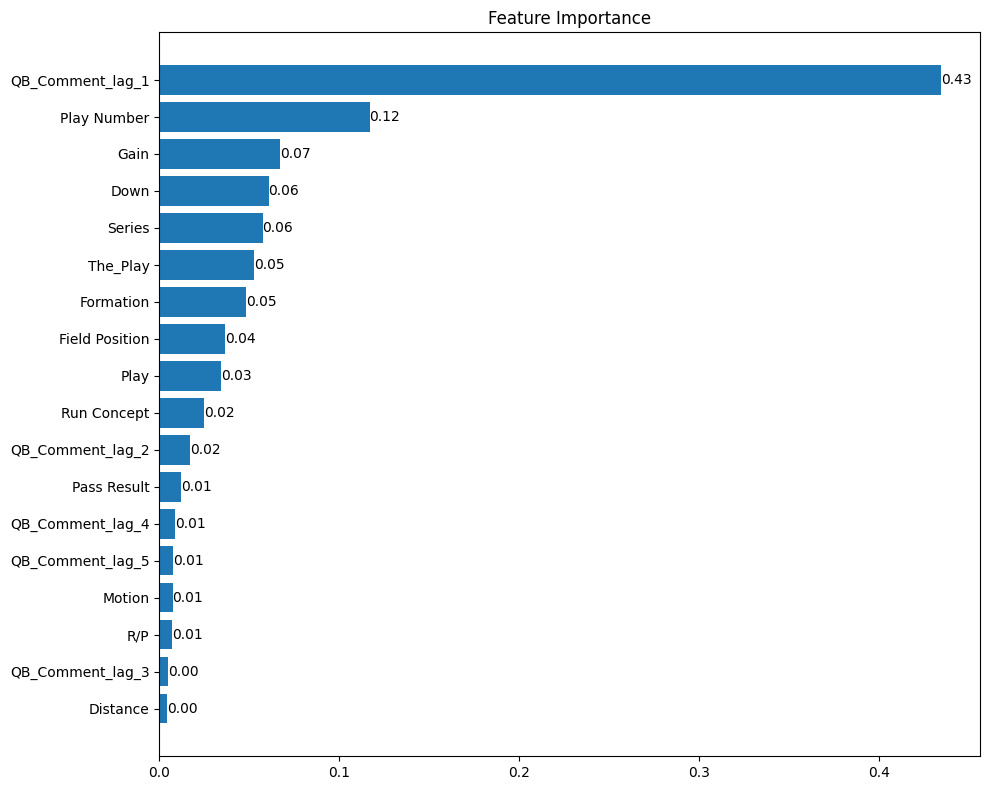

In [25]:
plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
bars = plt.barh(range(X_train_reduced.shape[1]), feature_importance[sorted_idx], align='center')
plt.yticks(range(X_train_reduced.shape[1]), X_train_reduced.columns[sorted_idx])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top

# Add annotations to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center')

plt.tight_layout()
plt.show()

In [26]:
# Function to predict the probability of the next play
def predict_next_play(sample, model, label_encoders):
    # Prepare the data (ensure it has the same format as the training data)
    prepared_sample = sample[relevant_features].to_numpy().reshape(1, -1)

    # Predict the probabilities for each possible outcome
    probabilities = model.predict_proba(prepared_sample)[0]
    outcome_labels = label_encoders['QB Comment'].classes_

    # Mapping the probabilities to the corresponding outcomes
    prob_dict = dict(zip(outcome_labels, probabilities))

    # Sorting the probabilities in descending order
    sorted_prob_dict = dict(sorted(prob_dict.items(), key=lambda item: item[1], reverse=True))

    return sorted_prob_dict

In [27]:
# Example usage of the prediction function with the holdout data
# Select a single sample (row) from the holdout dataset
example_data = holdout_features.iloc[5]  # Adjust the index if you want to test a different sample

In [28]:
# Predicting probabilities for the next play
predicted_probabilities = predict_next_play(example_data, gb_classifier_best, label_encoders)

print("Predicted Probabilities for Each Possible Outcome of the Next Play:")
for outcome, prob in predicted_probabilities.items():
    print(f"  {outcome}: {prob:.4f}")

Predicted Probabilities for Each Possible Outcome of the Next Play:
  INTERCEPTION: 0.4653
  PUNT: 0.4011
  INTERCEPTION-TD: 0.0336
  FIELD GOAL: 0.0277
  DOWNS: 0.0155
  TOUCHDOWN: 0.0151
  END OF GAME: 0.0105
  FUMBLE: 0.0104
  END OF HALF: 0.0104
  MISSED FG: 0.0104


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
